 **Import necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import pickle


 **Loading datasets**

In [ ]:
movies = pd.read_csv("/content/movies.csv")
ratings = pd.read_csv("/content/ratings.csv")

**Merging datasets**

In [ ]:
data = pd.merge(movies, ratings, on='movieId')

In [ ]:
data.head()

,movieId,title,genres,userId,rating,timestamp
0,8983,House of Flying Daggers (Shi mian mai fu) (2004),Action|Drama|Romance,113150,4.0,1453297690
1,5013,Gosford Park (2001),Comedy|Drama|Mystery,44147,4.0,1107142234
2,318,"Shawshank Redemption, The (1994)",Crime|Drama,15958,4.0,1523508853
3,1976,Friday the 13th Part 3: 3D (1982),Horror,66855,1.0,1013405997
4,216,Billy Madison (1995),Comedy,57640,3.0,975271323


#**Data Preprocessing**

In [ ]:
data.count()

,0
movieId,19568
title,19568
genres,19568
userId,19568
rating,19568
timestamp,19568


**Checking for missing values**

In [ ]:
missing_row = data[data.isnull().any(axis=1)]
missing_row

,movieId,title,genres,userId,rating,timestamp


**Checking for duplicates**

In [ ]:
duplicates=data.duplicated()
duplicates

,0
0,False
1,False
2,False
3,False
4,False
...,...
19563,False
19564,False
19565,False
19566,False


In [ ]:
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.head()

,movieId,title,genres,userId,rating,timestamp
0,8983,House of Flying Daggers (Shi mian mai fu) (2004),Action|Drama|Romance,113150,4.0,2016-01-20 13:48:10
1,5013,Gosford Park (2001),Comedy|Drama|Mystery,44147,4.0,2005-01-31 03:30:34
2,318,"Shawshank Redemption, The (1994)",Crime|Drama,15958,4.0,2018-04-12 04:54:13
3,1976,Friday the 13th Part 3: 3D (1982),Horror,66855,1.0,2002-02-11 05:39:57
4,216,Billy Madison (1995),Comedy,57640,3.0,2000-11-26 20:42:03


# **Data Visualization**

**Number of movies per genre**

<ipython-input-11-45a4cab829e3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


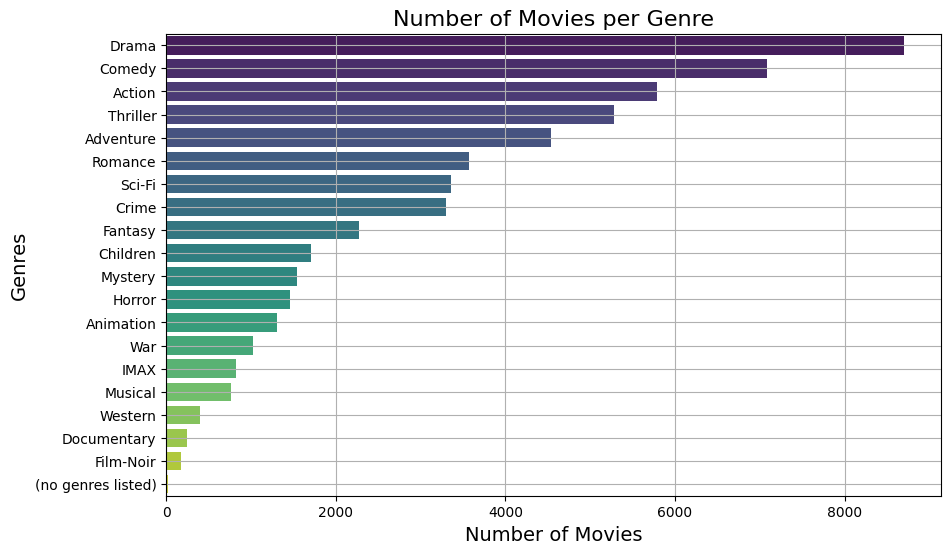

In [ ]:
data['genres'] = data['genres'].str.split('|')
all_genres = data['genres'].explode()
genre_counts = all_genres.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Number of Movies per Genre', fontsize=16)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Genres', fontsize=14)
plt.grid(True)
plt.show()


**Number of movies per each rating**

<ipython-input-12-79289a0227db>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratings_count.index, y=ratings_count.values, palette='viridis')


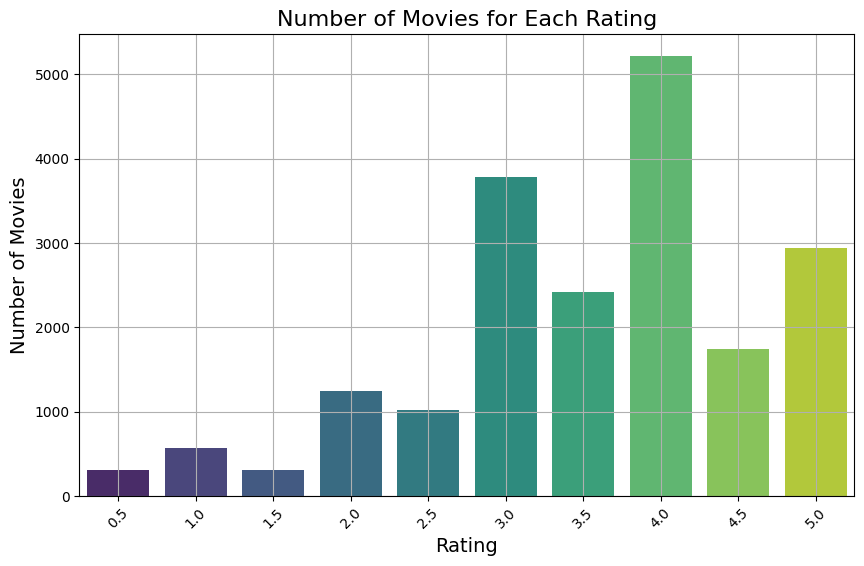

In [ ]:
ratings_count = data.groupby('rating')['movieId'].count()

plt.figure(figsize=(10, 6))
sns.barplot(x=ratings_count.index, y=ratings_count.values, palette='viridis')
plt.title('Number of Movies for Each Rating', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Encoding Id's**

In [ ]:
# Encode userId and movieId
user_enc = LabelEncoder()
data['user'] = user_enc.fit_transform(data['userId'].values)
movie_enc = LabelEncoder()
data['movie'] = movie_enc.fit_transform(data['movieId'].values)

In [ ]:
# Get the number of unique movies
num_movies = data['movie'].nunique()
movie_ids = data['movie'].unique()

print(f"Number of unique movies: {num_movies}")
print(f"Movie IDs: {movie_ids}")

Number of unique movies: 5088
Movie IDs: [3175 2371  215 ... 3028 4258 2390]


In [ ]:
# Get the number of unique users
num_users = data['user'].nunique()
user_ids = data['user'].unique()

print(f"\nNumber of unique users: {num_users}")
print(f"User IDs: {user_ids}")



Number of unique users: 16348
User IDs: [11345  4410  1584 ...  6825 13511 10770]


## **Collaborative Filtering**

**Interaction Matrix**

In [ ]:
interaction_matrix = data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
print(interaction_matrix)

movieId  1       2       3       5       6       7       8       9       \
userId                                                                    
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
18          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
23          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
43          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
162516      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
162521      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
162529      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
162533      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
162534      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  10      11     

In [ ]:
#Calculating cosine similarity
cosine_sim = cosine_similarity(interaction_matrix)
cosine_sim=pd.DataFrame(cosine_sim)
print(cosine_sim)

       0      1      2      3      4      5      6      7      8      9      \
0        1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
16343    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
16344    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
16345    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
16346    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
16347    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  16338  16339  16340  16341  16342  1634

**User based recommendations**

In [ ]:
def get_recommendations(userId):
    userId = int(userId)
    if userId not in user_ids:
        print(f"User {userId} not found in the similarity matrix.")
        return []

    index = np.where(user_ids == userId)[0][0]

    sim_scores = cosine_sim[index]

    similar_users_indices = np.argsort(sim_scores)[::-1]

    similar_users = [(user_ids[i], sim_scores[i]) for i in similar_users_indices if i < len(user_ids) and user_ids[i] != userId]

    if not similar_users:
        print(f"No similar users found for user {userId}.")
        return []

    top_similar_user_id, top_similarity_score = similar_users[0]

    recommended_movie_ids = []

    if top_similar_user_id in interaction_matrix.index:
        rated_movies = interaction_matrix.loc[top_similar_user_id]
        rated_movie_ids = rated_movies[rated_movies > 2].index.tolist()

        if rated_movie_ids:
            recommended_movie_ids.extend(rated_movie_ids)
    recommended_movie_ids = list(set(recommended_movie_ids))

    if not recommended_movie_ids:
        print(f"No recommendations found for user {userId}.")
        return []

    recommended_movie_titles = movies[movies['movieId'].isin(recommended_movie_ids)]['title'].tolist()

    return recommended_movie_titles

recommended_movie_titles = get_recommendations(44147)

print(recommended_movie_titles)


['Tales from the Crypt Presents: Bordello of Blood (1996)']


## **Content-Based Filtering**

In [ ]:
stemmer = PorterStemmer()

def stem_genres(genre_string):
    if isinstance(genre_string, str):
        genres = genre_string.split('|')
    elif isinstance(genre_string, list):
        genres = genre_string
    else:
        return ''

    stemmed_genres = [stemmer.stem(genre.lower()) for genre in genres]
    return '|'.join(stemmed_genres)

data['stemmed_genres'] = data['genres'].apply(stem_genres)

print(data[['genres', 'stemmed_genres']])


                             genres           stemmed_genres
0          [Action, Drama, Romance]      action|drama|romanc
1          [Comedy, Drama, Mystery]     comedi|drama|mysteri
2                    [Crime, Drama]              crime|drama
3                          [Horror]                   horror
4                          [Comedy]                   comedi
...                             ...                      ...
19563     [Action, Comedy, Romance]     action|comedi|romanc
19564              [Horror, Sci-Fi]            horror|sci-fi
19565                      [Comedy]                   comedi
19566  [Action, Adventure, Fantasy]  action|adventur|fantasi
19567            [Horror, Thriller]          horror|thriller

[19568 rows x 2 columns]


In [ ]:
# Create TF-IDF matrix
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(data['stemmed_genres'])

In [ ]:
# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

**Movie based recommendations**

In [ ]:
def get_recommendations(title):
    title = title.strip()

    if title not in data['title'].values:
        return f"Movie '{title}' not found in the dataset."

    idx = data[data['title'] == title].index[0]

    if idx < 0 or idx >= cosine_sim.shape[0]:
        return f"Index {idx} is out of bounds for the cosine similarity matrix."

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:3]

    movie_indices = [i[0] for i in sim_scores]

    recommended_titles = data['title'].iloc[movie_indices].tolist()
    return recommended_titles

print(get_recommendations('Minority Report (2002)'))


['Minority Report (2002)', 'Minority Report (2002)']


**Genre based recommendations**

In [ ]:
def get_recommendations_by_genre(input_genre):
    stemmed_input_genre = stem_genres(input_genre)

    input_tfidf = tfidf.transform([stemmed_input_genre])

    sim_scores = cosine_similarity(input_tfidf, tfidf_matrix)

    sim_scores = list(enumerate(sim_scores[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    movie_indices = [i[0] for i in sim_scores[1:4]]

    recommended_titles = data['title'].iloc[movie_indices].tolist()
    return recommended_titles

print(get_recommendations_by_genre('Action|Sci-Fi'))

['Universal Soldier (1992)', 'Starship Troopers (1997)', 'Universal Soldier (1992)']


In [ ]:
#saving data
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# Save the TF-IDF model
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [ ]:
#Save the TF-IDF matrix
with open('tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

In [ ]:
#saving required function
with open('recommendations.py', 'w') as f:
    f.write("""
    # Function to get recommendations based on a given genre
def get_recommendations_by_genre(input_genre):
    # Stem the input genre
    stemmed_input_genre = stem_text(input_genre)

    # Create a TF-IDF vector for the input genre
    input_tfidf = tfidf.transform([stemmed_input_genre])

    # Compute cosine similarity of input genre with the existing movies
    sim_scores = cosine_similarity(input_tfidf, tfidf_matrix)

    # Sort the movies based on the similarity scores
    sim_scores = list(enumerate(sim_scores[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top 3 most similar movies
    movie_indices = [i[0] for i in sim_scores[1:4]]  # Exclude the first one (itself)

    # Return the top similar movies
    return data['title'].iloc[movie_indices]

# Example of getting recommendations for a specific genre
print(get_recommendations_by_genre('Action|Sci-Fi'))""")


In [ ]:
from google.colab import files
files.download('recommendations.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>